In [25]:
from scipy.linalg import block_diag
import autograd.numpy as np
import matplotlib.pyplot as plt
import ssm

from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import get_spike_events, kalman_filter, bin_spikes, butter_filter, plot_dynamics_2d, plot_dynamics_3d
from matplotlib import colormaps
import pandas as pd

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.mplot3d import Axes3D 

%matplotlib inline

# Get data

In [2]:
mat = loadmat("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt2.mat")
mat = mat['data']

print(mat.dtype.names)

('totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success')


In [3]:
data_struct = mat[0, 0]  # MATLAB structs are 2D arrays even if 1x1
data = {field: data_struct[field] for field in mat.dtype.names}

In [4]:
data.keys()

dict_keys(['totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success'])

# Get single-reach trials

In [5]:
control_idxs = np.where(data["pattern_id"] == 0)[0]
control_idxs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  21,  27,  33,  39,  45,  51,  57,  63,  69,  75,
        81,  87,  93,  99, 105, 111, 117, 123, 129, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 440, 441,
       442, 443, 444, 445, 446, 447, 448, 449])

In [6]:
stim_idxs = np.where(data["pattern_id"][:150] > 2)[0]

# control_idxs = np.intersect1d(control_idxs, stim_idxs)
# con
control_idxs = np.sort(np.concatenate((control_idxs, stim_idxs)))

In [7]:
# get no laser trials
control_idxs = np.intersect1d(control_idxs, np.where(data["single"] == 1)[1])

In [8]:
#control_idxs = np.sort(np.concatenate((a, b)))
control_idxs

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  12,  14,  15,
        17,  19,  20,  21,  23,  24,  30,  33,  36,  39,  40,  43,  44,
        45,  46,  49,  50,  51,  53,  54,  60,  61,  62,  63,  67,  69,
        70,  71,  74,  77,  81,  82,  88,  89,  91, 105, 107, 116, 117,
       137, 139, 145, 148])

In [9]:
np.unique(data["pattern_id"][control_idxs])

array([ 0, 14, 17, 20], dtype=uint8)

## Get relevant time information

In [10]:
cue_times = data["cue_rec_time"][:, :150]
cue_times[:, control_idxs]

array([[  14310.86566601,   31635.98602851,   66118.75767016,
          83391.57934485,  100671.38676484,  117878.88228075,
         135202.39780987,  152469.08335693,  169748.98517889,
         187076.46559048,  221580.66647786,  256113.84876805,
         343834.9853677 ,  378401.3027471 ,  412964.5048617 ,
         430223.16624186,  447413.10299254,  481960.06796941,
         499231.75682054,  603021.71245162,  654737.65694326,
         706335.69338242,  758001.60483338,  775155.48003398,
         826860.47389786,  844093.36354196,  861313.50892099,
         878540.9232512 ,  930339.75266686,  947557.06598697,
         964758.89738507,  999343.5287454 , 1016540.9232512 ,
        1120486.35891627, 1137781.83706221, 1155099.87727745,
        1172344.18955914, 1241575.09676201, 1276101.01010101,
        1293329.17964694, 1310604.83338053, 1362412.63098272,
        1414270.55602757, 1483298.49900878, 1500421.5047673 ,
        1604049.56103087, 1621268.29038044, 1655724.06306051,
        

In [11]:
lift_times = data["lift_ms"][:, :150]
lift_times[:, control_idxs]

array([[310., 280., 330., 320., 300., 250., 270.,  90., 260., 260., 230.,
        230., 310., 290., 200., 280., 220., 270., 270., 300., 230., 290.,
        290., 310., 270., 320., 280., 290., 250., 270., 250., 280., 270.,
        290., 270., 270., 270., 260., 300., 320., 310., 310., 280., 280.,
        340., 270., 300., 310., 300., 300., 290., 200., 290., 340., 250.,
        220.]])

In [12]:
mouth_times = data["mouth_ms"][:, :150]
mouth_times[:, control_idxs]

array([[540., 540., 560., 570., 520., 540., 600., 460., 510., 490., 500.,
        530., 510., 520., 510., 630., 510., 480., 520., 570., 490., 670.,
        590., 570., 510., 640., 520., 560., 480., 520., 530., 490., 590.,
        520., 550., 570., 620., 520., 510., 550., 580., 650., 510., 520.,
        570., 480., 570., 550., 570., 530., 500., 560., 530., 570., 590.,
        480.]])

## Get the AP.bin file

In [13]:
from real_spike.utils import get_sample_data, get_meta
import tifffile

In [14]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.meta")

In [15]:
meta_data = get_meta(meta_path)

In [16]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 166298223)

## Get conversion params

In [17]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

In [18]:
vmax

0.6

In [19]:
imax

512.0

In [20]:
gain

500.0

# Get trials

In [21]:
def get_trials(idxs, bin_size):
    
    model_data = list()
    
    for i in tqdm(idxs):
        trial_no = i
        # get time points in ap space
        lift_time = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)
        
        # get end of behavior = mouth (260ms) + 300ms 
        end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260) / 1_000 * 30_000)

    
        trial = ap_data[:150, lift_time:end_behavior]
    
        conv_data = 1e6 * trial / vmax / imax / gain
    
        filt_data = butter_filter(conv_data, 1_000, 30_000)
    
        c_start = int(cue_times[:, trial_no] / 1_000 * 30_000)
        m_start = c_start - (30 * 2000)
        trial_median = ap_data[:150, m_start:c_start]
    
        trial_median = 1e6 * trial_median / vmax / imax / gain
        trial_median = butter_filter(trial_median, 1_000, 30_000)
        
        median = np.median(trial_median, axis=1)
    
        spike_ixs, counts = get_spike_events(filt_data, median)
        
        a = np.zeros((filt_data.shape[0], filt_data.shape[1]))
    
        for i, sc in enumerate(spike_ixs):
            a[i, sc] = 1
    
        b = bin_size * 30 # 30ms per bin
        binned_spikes = bin_spikes(a, b)
    
        lift_start = int(50 / bin_size)

        lift = int(data["lift_ms"][0, trial_no] / bin_size) 
        # grab duration
        grab = int(data["grab_ms"][0, trial_no] / bin_size)
        # mouth duration 
        mouth = int(data["mouth_ms"][0, trial_no] / bin_size)
    
        lift_start = int(50 / bin_size)
        grab_start = lift_start + (grab - lift)
        mouth_start = lift_start + (mouth-lift)

        model_data.append(np.asarray(binned_spikes[:, lift_start:mouth_start+1].T, dtype=int))

    return model_data

In [22]:
bin_size = 10

In [23]:
model_data = get_trials(control_idxs, bin_size)

  0%|                                          | 0/56 [00:00<?, ?it/s]/tmp/ipykernel_60812/2899079444.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lift_time = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)
/tmp/ipykernel_60812/2899079444.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260) / 1_000 * 30_000)
/tmp/ipykernel_60812/2899079444.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing thi

# Fit the model

In [24]:
state_dim = 3
obs_dim = model_data[0].shape[1] 

plds = ssm.LDS(obs_dim, state_dim, emissions="poisson", emission_kwargs=dict(link="softplus"))

elbos, q = plds.fit(model_data, method="laplace_em", num_iters=8)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

# Visualize the results

## Dynamics

In [27]:
A_est = plds.dynamics.A
b_est = plds.dynamics.b

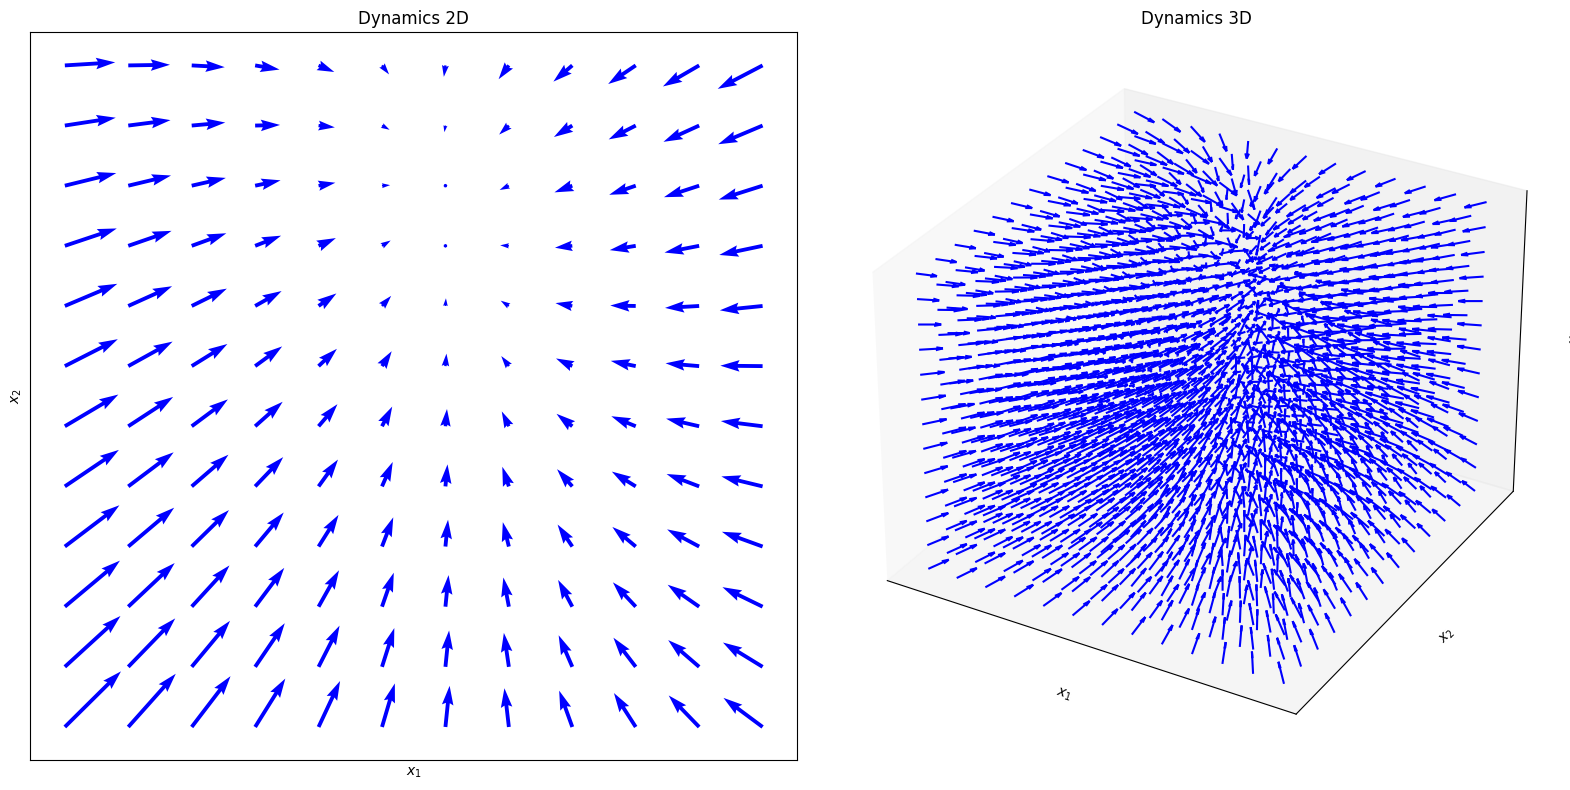

In [62]:
fig = plt.figure(figsize=(16, 8))

# 2D subplot
ax1 = fig.add_subplot(1, 2, 1)
plot_dynamics_2d(A_est[:2, :2], b_est[:2], ax1, npts=12)
ax1.set_title('Dynamics 2D')
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")

ax1.set_xticks([])
ax1.set_yticks([])

# 3D subplot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
plot_dynamics_3d(A_est, b_est, ax2, npts=13, colors="red")

ax2.set_title('Dynamics 3D')

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])

ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
ax2.set_zlabel("$x_3$")

plt.tight_layout()

plt.savefig("/home/clewis/repos/realSpike/data/rb50_20250127/plds/dynamics.png")

plt.show()

## Posterior Means 2D

In [64]:
state_means = q.mean_continuous_states

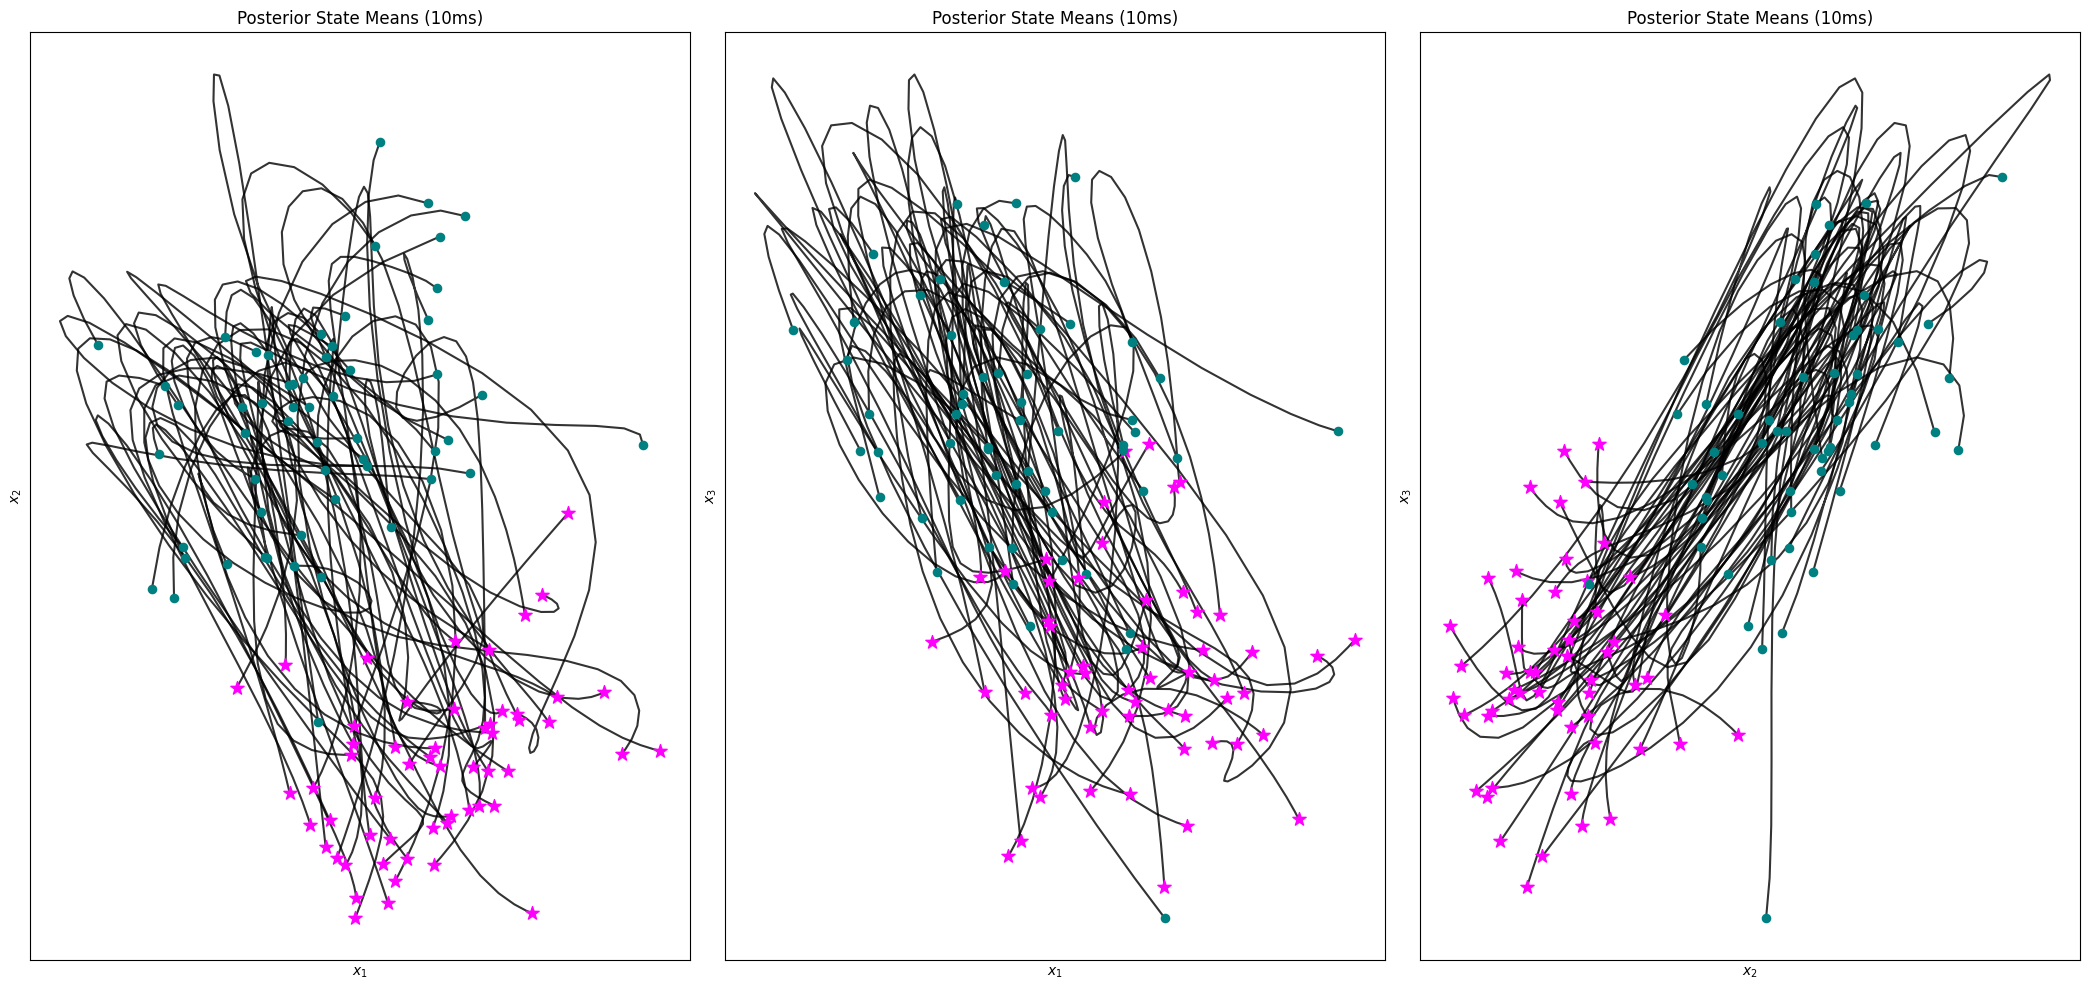

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(21, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, p in enumerate(state_means):

    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
   # mouth_start = lift_start + (mouth-lift)

    p = gaussian_filter1d(p, 4, axis=0)

    axes[0].plot(p[lift_start:, 0], p[lift_start:, 1], c="black", zorder=0, alpha=0.8)

    axes[0].scatter(p[lift_start, 0], p[lift_start, 1], s=35, c="teal", zorder=1, alpha=1)
    #ax.scatter(p[grab - lift + lift_start, 0], p[grab-lift +lift_start, 1], p[grab-lift +lift_start, 2], s=10, c="red")
    axes[0].scatter(p[-1, 0], p[-1, 1], s=100, marker='*', c="magenta", zorder=1, alpha=1)

    axes[1].plot(p[lift_start:, 0], p[lift_start:, 2], c="black", zorder=0, alpha=0.8)

    axes[1].scatter(p[lift_start, 0], p[lift_start, 2], s=35, c="teal", zorder=1, alpha=1)
    #ax.scatter(p[grab - lift + lift_start, 0], p[grab-lift +lift_start, 1], p[grab-lift +lift_start, 2], s=10, c="red")
    axes[1].scatter(p[-1, 0], p[-1, 2], s=100, marker='*', c="magenta", zorder=1, alpha=1)

    axes[2].plot(p[lift_start:, 1], p[lift_start:, 2], c="black", zorder=0, alpha=0.8)

    axes[2].scatter(p[lift_start, 1], p[lift_start, 2], s=35, c="teal", zorder=1, alpha=1)
    #ax.scatter(p[grab - lift + lift_start, 0], p[grab-lift +lift_start, 1], p[grab-lift +lift_start, 2], s=10, c="red")
    axes[2].scatter(p[-1, 1], p[-1, 2], s=100, marker='*', c="magenta", zorder=1, alpha=1)


for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Posterior State Means ({bin_size}ms)")


# 0, 0 = x1 vs x2
axes[0].set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")


# 0, 1 = x1 vs x3
axes[1].set_xlabel("$x_1$")
axes[1].set_ylabel("$x_3$")

# 0, 2 = x2 vs x3
axes[2].set_xlabel("$x_2$")
axes[2].set_ylabel("$x_3$")

plt.tight_layout()

plt.savefig("/home/clewis/repos/realSpike/data/rb50_20250127/plds/state_means_2D.png")

## Posterior Means 3D

In [ ]:
# a single 3d plot of all 

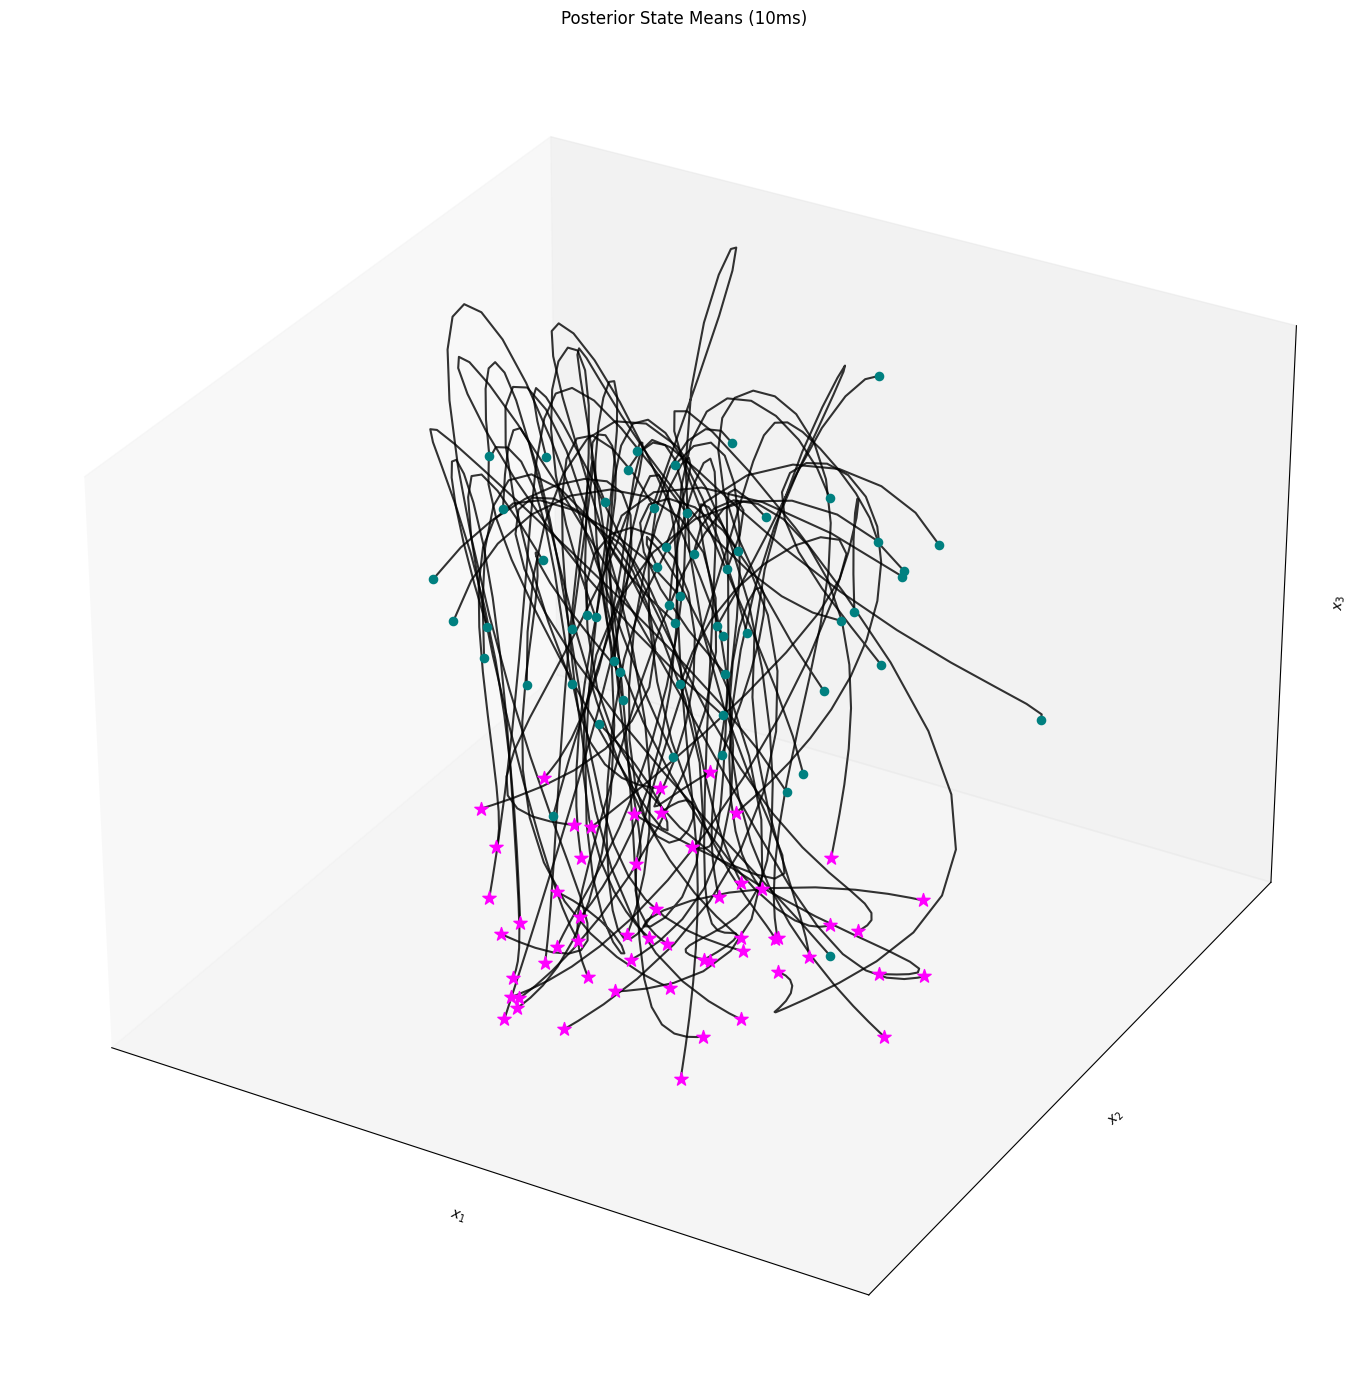

In [79]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

for i, p in enumerate(state_means):

    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
   # mouth_start = lift_start + (mouth-lift)

    p = gaussian_filter1d(p, 4, axis=0)

    ax.plot(p[lift_start:, 0], p[lift_start:, 1], p[lift_start:, 2], c="black", zorder=0, alpha=0.8)

    ax.scatter(p[lift_start, 0], p[lift_start, 1], p[lift_start, 2], s=35, c="teal", zorder=1, alpha=1)
    #ax.scatter(p[grab - lift + lift_start, 0], p[grab-lift +lift_start, 1], p[grab-lift +lift_start, 2], s=10, c="red")
    ax.scatter(p[-1, 0], p[-1, 1], p[-1, 2], s=100, marker='*', c="magenta", zorder=1, alpha=1)

ax.set_title(f"Posterior State Means ({bin_size}ms)")


ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")


plt.tight_layout()

plt.savefig("/home/clewis/repos/realSpike/data/rb50_20250127/plds/state_means_3D.png")

# Investigate rate parameter

In [89]:
# Emission parameters
C = plds.emissions.Cs     # shape (n_obs, latent_dim)
d = plds.emissions.ds # shape (n_obs,)

print(C.shape, d.shape)

# Link function: e.g., softplus
def softplus(x):
    return np.log1p(np.exp(x))

a = plds.smooth(state_means[0], model_data[0])

# Compute rate parameters
rates = softplus(a @ C.T + d)

(1, 150, 3) (1, 150)


In [ ]:
# plot the rate parameter over spike counts

In [91]:
rates.shape

(3, 24, 150)

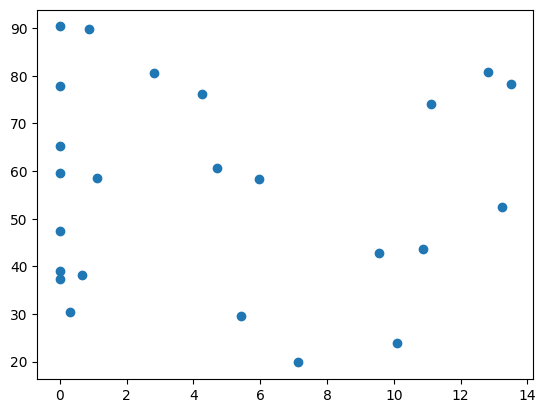

In [93]:
plt.scatter(rates[0, :, 0], rates[1, :, 0])

In [104]:
rates[0, :, 0].shape

(24,)

In [112]:
expected_rates = np.einsum('tk,ktn->tn', state_means[0], rates)

In [96]:
model_data[0].shape

(24, 150)

In [98]:
model_data[0][:, 0].shape

(24,)

In [113]:
expected_rates.shape

(24, 150)

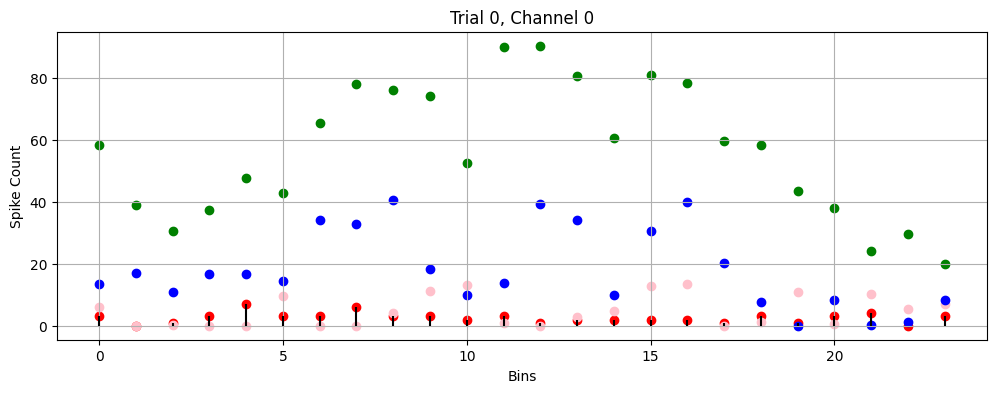

In [115]:
# Sample data
x = np.arange(0, model_data[0].shape[0])
y = model_data[0][:, 0]

# Stick plot
plt.figure(figsize=(12, 4))
plt.vlines(x, 0, y, color='black')  # vertical lines from 0 to y
plt.scatter(x, y, color='red')     # optional: highlight tips
plt.title("Trial 0, Channel 0")
plt.xlabel("Bins")
plt.ylabel("Spike Count")
plt.grid(True)

plt.scatter(x, rates[0, :, 0], color="pink")
plt.scatter(x, rates[1, :, 0], color="green")
plt.scatter(x, rates[2, :, 0], color="blue")

plt.show()